In [ ]:
import sklearn
import time
import pandas as pd   
from matplotlib import pyplot
from numpy import mean
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [ ]:
def robust_scale(df):
    numerical_columns = df.select_dtypes(include=['number']).columns
    # df.drop(columns=['RecordID','hospital_id'], inplace=True)
    scaler = RobustScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df
def standard_scale(df):
    numerical_columns = df.select_dtypes(include=['number']).columns
    # df.drop(columns=['RecordID','hospital_id'], inplace=True)
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

def knn_impute_numerical_columns(df, n_neighbors=10):
    df_imputed = df.copy()
    
    df_imputed.drop(columns=['RecordID','hospital_id'], inplace=True)
    
    categorical_columns = df_imputed.select_dtypes(exclude=['number']).columns
    numerical_cols = df_imputed.select_dtypes(include=['number']).columns
    
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])
    
    imputer = SimpleImputer(strategy='most_frequent')
    df_imputed[categorical_columns] = imputer.fit_transform(df_imputed[categorical_columns])
    
    # df_imputed = pd.get_dummies(df_imputed)

    return df_imputed

def roc_auc_cv(model, X, y, njobs=2, verbose=2):
    cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)
    predicted_probabilities = cross_val_score(model, X, y, scoring="roc_auc", cv=cv, n_jobs=njobs, verbose=verbose)

    return mean(predicted_probabilities)

def calculate_roc_auc(model, X_test, y_test):
    md_probs = model.predict_proba(X_test)
    md_probs = md_probs[:, 1]
    md_auc = roc_auc_score(y_test, md_probs)
    return md_auc



In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
standard_scale(df)

In [ ]:
df_imputed = knn_impute_numerical_columns(df, n_neighbors=10)

In [ ]:
df_dropped = df_imputed.copy().dropna(axis=0)
df_dropped.shape
# missing_value_counts(df_dropped)

In [ ]:
df_onehot = pd.get_dummies(df_dropped)
df_onehot
df_onehot.shape

In [191]:
X = df_onehot.loc[:, df_onehot.columns != "hospital_death"]
y = df_onehot[["hospital_death"]]

X.shape, y.shape

((50000, 93), (50000, 1))

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X.shape

(50000, 93)

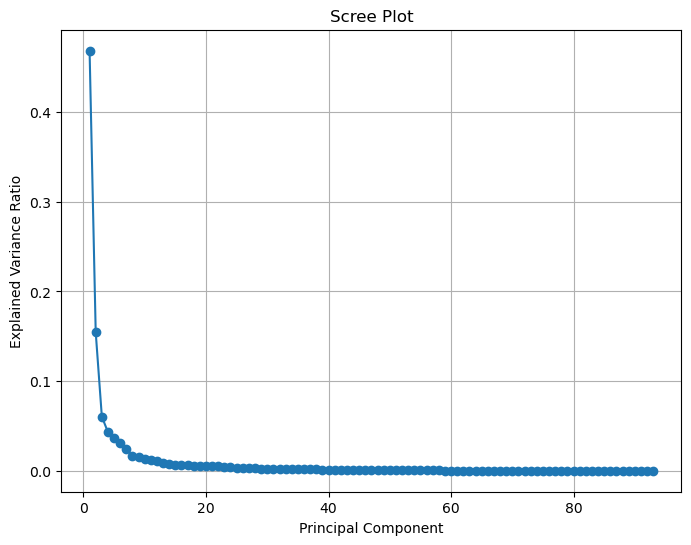

In [193]:
import matplotlib.pyplot as plt

# Fit PCA on your preprocessed data
pca_transformer = PCA()
X_pca = pca_transformer.fit_transform(X)

# Get the explained variance ratio for each component
explained_variance_ratio = pca_transformer.explained_variance_ratio_

# Plot the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


In [ ]:
X_train.shape

In [ ]:
n_components = 20
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# xgb_classifier = XGBClassifier(n_estimators=100, max_depth=3, random_state=42)
# xgb_classifier.fit(X_train_pca, y_train)

cb = CatBoostClassifier(iterations=590, learning_rate=0.09, depth=5,
                           loss_function='Logloss', verbose=20, eval_metric='AUC', l2_leaf_reg=2)


bagging_classifier = BaggingClassifier(cb, n_estimators=10, random_state=42, n_jobs=2)

bagging_classifier.fit(X_train, y_train)
calculate_roc_auc(bagging_classifier, X_test, y_test)



In [ ]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=1000, max_depth=7, random_state=0, n_jobs=3)
estimator.fit(X, y)

# Get feature importances
feature_importances = estimator.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_num = 50
selected_features = feature_importance_df['Feature'][:feature_num]
selected_features

In [ ]:
X = X[selected_features]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X.shape

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_catboost = pd.read_csv('train.csv')
df_catboost = pd.get_dummies(df_catboost)

X = df_catboost.loc[:, df_catboost.columns != "hospital_death"]
y = df_catboost[["hospital_death"]]



In [ ]:
base_model = XGBClassifier(n_estimators=800, max_depth=4, learning_rate=0.038, min_child_weight=1, colsample_bytree=0.8, alpha=0.1, gamma=1)
base_model.fit(X_train, y_train)
calculate_roc_auc(base_model, X_test, y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = XGBClassifier(n_estimators=800, max_depth=4, learning_rate=0.038, min_child_weight=1, colsample_bytree=0.8, alpha=0.1, gamma=1, verbose=2)

bagging_classifier = BaggingClassifier(base_model, n_estimators=5, random_state=42)

bagging_classifier.fit(X_train, y_train)
calculate_roc_auc(bagging_classifier, X_test, y_test)

In [ ]:
from catboost import CatBoostClassifier, Pool


model = CatBoostClassifier(
    iterations=590,
    depth=5,
    learning_rate=0.09,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=69,
    verbose=20,
    l2_leaf_reg=2,
    border_count=80,
    leaf_estimation_iterations=10,
    # subsample=0.8,
    # min_data_in_leaf=3,
    # colsample_bylevel=0.8,
    
)
roc_auc_cv(model, X, y)

# model.fit(X_train, y_train)
# calculate_roc_auc(model, X_test, y_test)

In [217]:
from xgboost import XGBClassifier

df = pd.read_csv('train.csv')
df = pd.get_dummies(df)
X = df.loc[:, df.columns != "hospital_death"]
y = df[["hospital_death"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = CatBoostClassifier(
    iterations=590,
    depth=5,
    learning_rate=0.09,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=69,
    verbose=20,
    l2_leaf_reg=2,
    border_count=80,
    leaf_estimation_iterations=10,
)
# model.fit(X_train, y_train)
# calculate_roc_auc(model, X_test, y_test)
# roc_auc_cv(model, X, y)
model.fit(X, y)


0:	total: 12ms	remaining: 7.06s
20:	total: 150ms	remaining: 4.06s
40:	total: 307ms	remaining: 4.11s
60:	total: 451ms	remaining: 3.91s
80:	total: 596ms	remaining: 3.75s
100:	total: 749ms	remaining: 3.63s
120:	total: 896ms	remaining: 3.47s
140:	total: 1.04s	remaining: 3.31s
160:	total: 1.2s	remaining: 3.2s
180:	total: 1.34s	remaining: 3.04s
200:	total: 1.49s	remaining: 2.89s
220:	total: 1.66s	remaining: 2.77s
240:	total: 1.86s	remaining: 2.7s
260:	total: 2.02s	remaining: 2.55s
280:	total: 2.17s	remaining: 2.39s
300:	total: 2.32s	remaining: 2.23s
320:	total: 2.48s	remaining: 2.08s
340:	total: 2.66s	remaining: 1.94s
360:	total: 2.88s	remaining: 1.83s
380:	total: 3.03s	remaining: 1.66s
400:	total: 3.18s	remaining: 1.5s
420:	total: 3.32s	remaining: 1.33s
440:	total: 3.48s	remaining: 1.17s
460:	total: 3.62s	remaining: 1.01s
480:	total: 3.79s	remaining: 858ms
500:	total: 3.93s	remaining: 698ms
520:	total: 4.09s	remaining: 542ms
540:	total: 4.35s	remaining: 394ms
560:	total: 4.5s	remaining: 233

In [ ]:
X_train.shape

In [ ]:
df = pd.read_csv('train.csv')
df = robust_scale(df)
df = knn_impute_numerical_columns(df, n_neighbors=10)
df = pd.get_dummies(df)

X = df.loc[:, df.columns != "hospital_death"]
y = df[["hospital_death"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [200]:
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [201]:
model = RandomForestClassifier(n_estimators=700, max_depth=7, random_state=0,
                               n_jobs=3, min_samples_leaf=2, min_samples_split=2, verbose=2)

model.fit(X_train_pca, y_train)
calculate_roc_auc(model, X_test_pca, y_test)


/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700building tree 8 of 700

building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    1.3s


building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70 of 700
building tree 71 of 700
building tree 72 of 700
building tree 73 of 700
building tree 74 of 700
building tree 75 of 700
building tree 76 of 700
building tree 77 of 700
building tree 78 of 700
building tree 79 of 700
building tree 80 of 700
building tree 81 of 700
building tree 82 of 700
building tree 83 of 700
building tree 84

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:    5.8s


building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700
building tree 166 of 700
building tree 167 of 700
building tree 168 of 700
building tree 169 of 700
building tree 170 of 700
building tree 171 of 700
building tree 172 of 700
building tree 173 of 700
building tree 174 of 700
building tree 175 of 700
building tree 176 of 700
building tree 177 of 700
building tree 178 of 700
building tree 179 of 700
building tree 180 of 700
building tree 181 of 700
building tree 182 of 700
building tree 183 of 700
building tree 184 of 700
building tree 185 of 700
building tree 186 of 700
building tree 187 of 700
building tree 188 of 700
building tree 189 of 700
building tree 190 of 700
building tree 191 of 700
building tree 192 of 700
building tree 193 of 700
building tree 194 of 700
building tree 195 of 700
building tree 196 of 700
building tree 197 of 700
building tree 198 of 700
building tree 199 of 700
building tree 200 of 700


[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:   12.9s


building tree 364 of 700
building tree 365 of 700
building tree 366 of 700
building tree 367 of 700
building tree 368 of 700
building tree 369 of 700
building tree 370 of 700
building tree 371 of 700
building tree 372 of 700
building tree 373 of 700
building tree 374 of 700
building tree 375 of 700
building tree 376 of 700
building tree 377 of 700
building tree 378 of 700
building tree 379 of 700
building tree 380 of 700
building tree 381 of 700
building tree 382 of 700
building tree 383 of 700
building tree 384 of 700
building tree 385 of 700
building tree 386 of 700
building tree 387 of 700
building tree 388 of 700
building tree 389 of 700
building tree 390 of 700
building tree 391 of 700
building tree 392 of 700
building tree 393 of 700
building tree 394 of 700
building tree 395 of 700
building tree 396 of 700
building tree 397 of 700
building tree 398 of 700
building tree 399 of 700
building tree 400 of 700
building tree 401 of 700
building tree 402 of 700
building tree 403 of 700


[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed:   22.5s


building tree 646 of 700
building tree 647 of 700
building tree 648 of 700
building tree 649 of 700
building tree 650 of 700
building tree 651 of 700
building tree 652 of 700
building tree 653 of 700
building tree 654 of 700
building tree 655 of 700
building tree 656 of 700
building tree 657 of 700
building tree 658 of 700
building tree 659 of 700
building tree 660 of 700
building tree 661 of 700
building tree 662 of 700
building tree 663 of 700
building tree 664 of 700
building tree 665 of 700
building tree 666 of 700
building tree 667 of 700
building tree 668 of 700
building tree 669 of 700
building tree 670 of 700
building tree 671 of 700
building tree 672 of 700
building tree 673 of 700
building tree 674 of 700
building tree 675 of 700
building tree 676 of 700
building tree 677 of 700
building tree 678 of 700
building tree 679 of 700
building tree 680 of 700
building tree 681 of 700
building tree 682 of 700
building tree 683 of 700
building tree 684 of 700
building tree 685 of 700


[Parallel(n_jobs=3)]: Done 700 out of 700 | elapsed:   24.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 700 out of 700 | elapsed:    0.1s finished


0.8617519203295022

In [211]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

model1 = CatBoostClassifier(iterations=590, depth=5, learning_rate=0.09, loss_function='Logloss', eval_metric='AUC', random_seed=69, l2_leaf_reg=2, border_count=80, leaf_estimation_iterations=10)
model2 = XGBClassifier(n_estimators=800, max_depth=4, learning_rate=0.038, min_child_weight=1, colsample_bytree=0.8, alpha=0.1)
final_model = CatBoostClassifier(iterations=590, depth=5, learning_rate=0.09, loss_function='Logloss', eval_metric='AUC', random_seed=69, l2_leaf_reg=2, border_count=80, leaf_estimation_iterations=10)
model = StackingClassifier(estimators=[('catboost', model1), ('xgboost', model2)], final_estimator=final_model)

# Fit the voting classifier on the training data
model.fit(X_train, y_train)

calculate_roc_auc(model, X_test, y_test)

/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0:	total: 18.8ms	remaining: 11.1s
1:	total: 27.6ms	remaining: 8.1s
2:	total: 40ms	remaining: 7.83s
3:	total: 47.4ms	remaining: 6.94s
4:	total: 55.6ms	remaining: 6.51s
5:	total: 65.5ms	remaining: 6.38s
6:	total: 74.2ms	remaining: 6.18s
7:	total: 83.2ms	remaining: 6.05s
8:	total: 92.3ms	remaining: 5.96s
9:	total: 99.9ms	remaining: 5.8s
10:	total: 107ms	remaining: 5.66s
11:	total: 118ms	remaining: 5.67s
12:	total: 128ms	remaining: 5.69s
13:	total: 137ms	remaining: 5.62s
14:	total: 147ms	remaining: 5.64s
15:	total: 156ms	remaining: 5.58s
16:	total: 163ms	remaining: 5.51s
17:	total: 172ms	remaining: 5.48s
18:	total: 181ms	remaining: 5.45s
19:	total: 189ms	remaining: 5.38s
20:	total: 195ms	remaining: 5.28s
21:	total: 201ms	remaining: 5.18s
22:	total: 206ms	remaining: 5.08s
23:	total: 213ms	remaining: 5.03s
24:	total: 220ms	remaining: 4.96s
25:	total: 226ms	remaining: 4.9s
26:	total: 232ms	remaining: 4.83s
27:	total: 240ms	remaining: 4.82s
28:	total: 246ms	remaining: 4.76s
29:	total: 252ms	re

/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a f

0:	total: 6.4ms	remaining: 3.77s
1:	total: 11ms	remaining: 3.22s
2:	total: 16.1ms	remaining: 3.16s
3:	total: 21.7ms	remaining: 3.18s
4:	total: 26.9ms	remaining: 3.14s
5:	total: 32.1ms	remaining: 3.13s
6:	total: 37.8ms	remaining: 3.15s
7:	total: 43.3ms	remaining: 3.15s
8:	total: 49.1ms	remaining: 3.17s
9:	total: 54.8ms	remaining: 3.18s
10:	total: 60.2ms	remaining: 3.17s
11:	total: 65.5ms	remaining: 3.16s
12:	total: 71.5ms	remaining: 3.17s
13:	total: 76.7ms	remaining: 3.15s
14:	total: 82.2ms	remaining: 3.15s
15:	total: 88ms	remaining: 3.16s
16:	total: 93.6ms	remaining: 3.15s
17:	total: 99ms	remaining: 3.15s
18:	total: 105ms	remaining: 3.16s
19:	total: 111ms	remaining: 3.17s
20:	total: 117ms	remaining: 3.16s
21:	total: 122ms	remaining: 3.15s
22:	total: 127ms	remaining: 3.12s
23:	total: 132ms	remaining: 3.12s
24:	total: 138ms	remaining: 3.11s
25:	total: 143ms	remaining: 3.11s
26:	total: 149ms	remaining: 3.11s
27:	total: 155ms	remaining: 3.11s
28:	total: 160ms	remaining: 3.1s
29:	total: 166

/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a f

0:	total: 4.98ms	remaining: 2.93s
1:	total: 9ms	remaining: 2.65s
2:	total: 13.4ms	remaining: 2.62s
3:	total: 18.4ms	remaining: 2.69s
4:	total: 23.7ms	remaining: 2.77s
5:	total: 28.5ms	remaining: 2.77s
6:	total: 33ms	remaining: 2.75s
7:	total: 37.7ms	remaining: 2.74s
8:	total: 41.7ms	remaining: 2.69s
9:	total: 46.1ms	remaining: 2.68s
10:	total: 51.5ms	remaining: 2.71s
11:	total: 55.7ms	remaining: 2.68s
12:	total: 61ms	remaining: 2.71s
13:	total: 65.8ms	remaining: 2.71s
14:	total: 70.1ms	remaining: 2.69s
15:	total: 74.3ms	remaining: 2.67s
16:	total: 79.1ms	remaining: 2.66s
17:	total: 84.5ms	remaining: 2.68s
18:	total: 88.8ms	remaining: 2.67s
19:	total: 97.5ms	remaining: 2.78s
20:	total: 103ms	remaining: 2.78s
21:	total: 108ms	remaining: 2.78s
22:	total: 113ms	remaining: 2.78s
23:	total: 117ms	remaining: 2.76s
24:	total: 123ms	remaining: 2.77s
25:	total: 128ms	remaining: 2.77s
26:	total: 133ms	remaining: 2.78s
27:	total: 138ms	remaining: 2.77s
28:	total: 142ms	remaining: 2.75s
29:	total: 

/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a f

0.8837555774714094

In [208]:
model.fit(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0:	total: 6.91ms	remaining: 4.07s
1:	total: 17.1ms	remaining: 5.02s
2:	total: 24.1ms	remaining: 4.72s
3:	total: 30.6ms	remaining: 4.49s
4:	total: 36.6ms	remaining: 4.28s
5:	total: 43.9ms	remaining: 4.27s
6:	total: 50.8ms	remaining: 4.23s
7:	total: 58.7ms	remaining: 4.27s
8:	total: 65.4ms	remaining: 4.22s
9:	total: 73.1ms	remaining: 4.24s
10:	total: 79.8ms	remaining: 4.2s
11:	total: 87.9ms	remaining: 4.23s
12:	total: 95.2ms	remaining: 4.22s
13:	total: 102ms	remaining: 4.21s
14:	total: 111ms	remaining: 4.26s
15:	total: 120ms	remaining: 4.3s
16:	total: 126ms	remaining: 4.25s
17:	total: 133ms	remaining: 4.23s
18:	total: 140ms	remaining: 4.22s
19:	total: 149ms	remaining: 4.23s
20:	total: 155ms	remaining: 4.21s
21:	total: 162ms	remaining: 4.17s
22:	total: 169ms	remaining: 4.15s
23:	total: 176ms	remaining: 4.16s
24:	total: 183ms	remaining: 4.14s
25:	total: 190ms	remaining: 4.12s
26:	total: 196ms	remaining: 4.1s
27:	total: 203ms	remaining: 4.07s
28:	total: 210ms	remaining: 4.05s
29:	total: 217

/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a f

0:	total: 7.21ms	remaining: 4.24s
1:	total: 13.9ms	remaining: 4.1s
2:	total: 20.5ms	remaining: 4s
3:	total: 26.2ms	remaining: 3.83s
4:	total: 35.5ms	remaining: 4.16s
5:	total: 44.8ms	remaining: 4.36s
6:	total: 55.2ms	remaining: 4.6s
7:	total: 64.9ms	remaining: 4.72s
8:	total: 73.5ms	remaining: 4.74s
9:	total: 82.2ms	remaining: 4.77s
10:	total: 92.1ms	remaining: 4.85s
11:	total: 101ms	remaining: 4.87s
12:	total: 109ms	remaining: 4.82s
13:	total: 117ms	remaining: 4.82s
14:	total: 126ms	remaining: 4.84s
15:	total: 135ms	remaining: 4.83s
16:	total: 141ms	remaining: 4.75s
17:	total: 147ms	remaining: 4.68s
18:	total: 154ms	remaining: 4.63s
19:	total: 161ms	remaining: 4.58s
20:	total: 167ms	remaining: 4.52s
21:	total: 172ms	remaining: 4.44s
22:	total: 178ms	remaining: 4.39s
23:	total: 184ms	remaining: 4.34s
24:	total: 190ms	remaining: 4.29s
25:	total: 196ms	remaining: 4.25s
26:	total: 203ms	remaining: 4.23s
27:	total: 209ms	remaining: 4.19s
28:	total: 217ms	remaining: 4.19s
29:	total: 223ms	r

/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/homebrew/Caskroom/miniforge/base/envs/imlenv/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a f

StackingClassifier(estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x28f53ca90>),
                               ('xgboost',
                                XGBClassifier(alpha=0.1, base_score=None,
                                              booster=None, callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=N...
                                                 feature_types=None, gamma=None,
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.038,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=4, max_leaves=None,
                                                 min_child_weight=1,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=800, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None, ...))

In [209]:
def generate_predictions_for_model(model, test_file, output_file):
    
    df = pd.read_csv(test_file)
    record_ids = df["RecordID"]
    
    standard_scale(df)
    df = knn_impute_numerical_columns(df, n_neighbors=10)
    df = pd.get_dummies(df)
    
    # n_components = 20
    # pca = PCA(n_components=n_components)
    # df = pca.fit_transform(df)

    # X_test = df[selected_features] 
    
    X_test = df.loc[:, df.columns != "hospital_death"]
    # X_test = df
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    
    # Create a DataFrame for the results
    result = pd.DataFrame({'RecordID': record_ids, 'hospital_death': probs})
    
    # Save the results to a CSV file
    result.to_csv(output_file, index=False, header=["RecordID", "hospital_death"])


In [ ]:
model.fit(X, y)

In [210]:
generate_predictions_for_model(bagging_classifier, "test.csv", "results96.csv")


In [ ]:
from lightgbm import LGBMClassifier

df = pd.read_csv('train.csv')
df = pd.get_dummies(df)
X = df.loc[:, df.columns != "hospital_death"]
y = df[["hospital_death"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [ ]:
params = {
   'objective': 'binary',
   'metric': 'binary_logloss',
   'boosting_type': 'gbdt',
   'num_leaves': 31,
   'learning_rate': 0.09,
   'feature_fraction': 0.6,
   'bagging_fraction': 0.8,
   'bagging_freq': 3,
   'n_estimators': 100,
   'subsample': 0.8,
}

model = LGBMClassifier(**params)

roc_auc_cv(model, X, y, verbose=3,njobs=2)
# model.fit(X_train, y_train)
# calculate_roc_auc(model, X_test, y_test)